# STEP 1: Import ALL the things!
[Following along here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics)

In [1]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

TensorFlow 2.x selected.


### (A) With Fraud Data

In [2]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### (B) With Loan Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("drive/My Drive/data")

In [0]:
raw_df_B = pd.read_csv('home-credit-default-risk/application_train.csv') 

## STEP 2: Examine Class Imbalance

In [8]:
### A
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [11]:
### B
repaid, defaulted = np.bincount(raw_df_B['TARGET'])
total = repaid + defaulted
print('Examples:\n    Total: {}\n    Defaulted: {} ({:.2f}% of total)\n'.format(
    total, defaulted, 100 * defaulted / total))


Examples:
    Total: 307511
    Defaulted: 24825 (8.07% of total)



# STEP 3: Clean, split and normalize the data


In [0]:
### A

# You don't want the `Time` column.
# The `Amount` column covers a huge range. Convert to log-space.

cleaned_df = raw_df.copy()
cleaned_df.pop('Time')
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [0]:
### B

# Temp "cleaning"

cleaned_df_B = raw_df_B.copy()
cols = ['TARGET','CNT_FAM_MEMBERS',
 'CNT_CHILDREN',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OWN_CAR_AGE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_BIRTH','AMT_INCOME_TOTAL']      
cleaned_df_B = pd.DataFrame(cleaned_df_B, columns=cols)

In [51]:
print(cleaned_df.shape)
print(cleaned_df_B.shape)

(284807, 30)
(307511, 10)


In [0]:
### A 

def get_split_data(df, target_label):
  # Use a utility from sklearn to split and shuffle our dataset.
  train_df, test_df = train_test_split(df, test_size=0.2)
  train_df, val_df = train_test_split(train_df, test_size=0.2)

  # Form np arrays of labels and features.
  train_labels = np.array(train_df.pop(target_label))
  bool_train_labels = train_labels != 0
  val_labels = np.array(val_df.pop(target_label))
  test_labels = np.array(test_df.pop(target_label))

  train_features = np.array(train_df)
  val_features = np.array(val_df)
  test_features = np.array(test_df)

  return train_df, train_labels, bool_train_labels, val_labels, test_labels, train_features, val_features, test_features


In [0]:
train_df, train_labels, bool_train_labels, val_labels, test_labels, train_features, val_features, test_features = get_split_data(cleaned_df, 'Class')

In [0]:
train_df_B, train_labels_B, bool_train_labels_B, val_labels_B, test_labels_B, train_features_B, val_features_B, test_features_B = get_split_data(cleaned_df_B, 'TARGET')

In [0]:
def scale_and_plot(train_df, train_labels, val_labels, test_labels, train_features, val_features, test_features, bool_train_labels, col1, col2):
  scaler = StandardScaler()
  train_features = scaler.fit_transform(train_features)

  val_features = scaler.transform(val_features)
  test_features = scaler.transform(test_features)

  train_features = np.clip(train_features, -5, 5)
  val_features = np.clip(val_features, -5, 5)
  test_features = np.clip(test_features, -5, 5)

  print('Training labels shape:', train_labels.shape)
  print('Validation labels shape:', val_labels.shape)
  print('Test labels shape:', test_labels.shape)

  print('Training features shape:', train_features.shape)
  print('Validation features shape:', val_features.shape)
  print('Test features shape:', test_features.shape)
  pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
  neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

  sns.jointplot(pos_df[col1], pos_df[col2],
                kind='hex', xlim = (-5,5), ylim = (-5,5))
  plt.suptitle("Positive distribution")

  sns.jointplot(neg_df[col1], neg_df[col2],
                kind='hex', xlim = (-5,5), ylim = (-5,5))
  _ = plt.suptitle("Negative distribution")

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


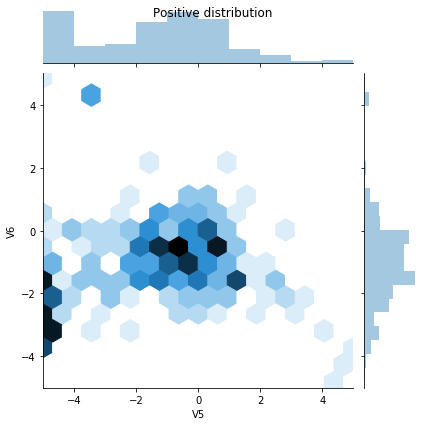

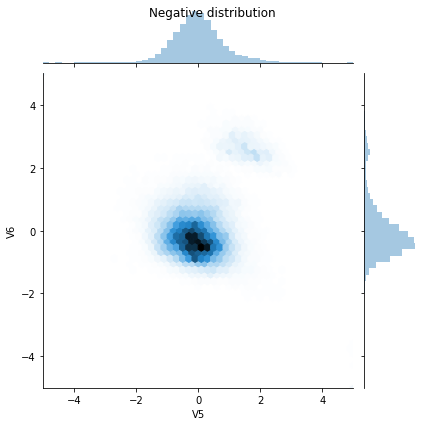

In [56]:
scale_and_plot(train_df, train_labels, val_labels, test_labels, train_features, val_features, test_features, bool_train_labels, 'V5', 'V6')

Training labels shape: (196806,)
Validation labels shape: (49202,)
Test labels shape: (61503,)
Training features shape: (196806, 9)
Validation features shape: (49202, 9)
Test features shape: (61503, 9)


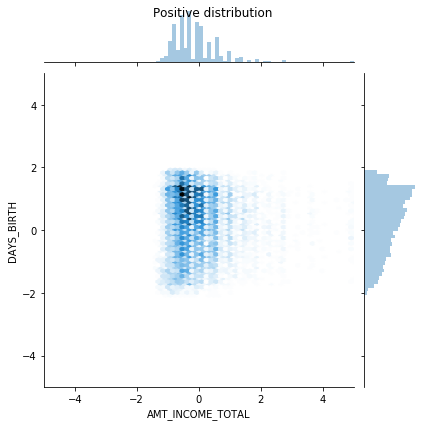

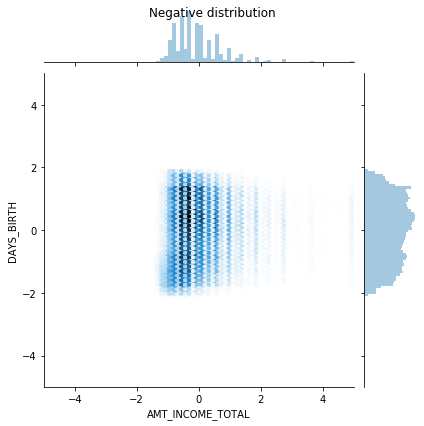

In [57]:
scale_and_plot(train_df_B, train_labels_B, val_labels_B, test_labels_B, train_features_B, val_features_B, test_features_B, bool_train_labels_B, 'AMT_INCOME_TOTAL','DAYS_BIRTH')